### Importing libraries

In [1]:
import pandas as pd
import datetime
from datetime import timedelta
import geopy.distance

### Importing the data

In [2]:
df = pd.read_csv("/Users/younesamor/Desktop/MMA/Winter I 2020/Enterprise Analytics/FInal/accidents.csv")

### Preprocessing of the data

In [3]:
df = df.drop("Unnamed: 0",axis=1)
start = df["Start_Time"].tolist()
end = df["End_Time"].tolist()
years = []
months =[]
days = []
hours =[]
ends = []
##Getting individual tokens to get the hour, month and  year
for time in start:
    years.append(time.split(" ")[0].split("-")[0])
    months.append(time.split(" ")[0].split("-")[1])
    days.append(time.split(" ")[0].split("-")[2])
    hours.append(time.split(" ")[1].split(":")[0])

### Calculating the duration of the accident

In [4]:
datetimeFormat = '%Y-%m-%d %H:%M:%S'
for begin,finish in zip(start,end):
    ends.append((datetime.datetime.strptime(finish, datetimeFormat) - datetime.datetime.strptime(begin, datetimeFormat)).seconds)

df["Start_Year"] = years
df["Start_Month"] = months
df["Start_Day"] = days
df["Start_Hour"] = hours
df["Accident_Duration"] = ends
df = df.drop("Start_Time",axis=1)
df = df.drop("End_Time",axis=1)

### Calculating the distance of the accident

In [5]:
df['End_Lng'] = df['End_Lng'].fillna(0)
df['End_Lat'] = df['End_Lat'].fillna(0)
start_lat = df["Start_Lat"].tolist()
start_long = df["Start_Lng"].tolist()
end_long = df["End_Lng"].tolist()
end_lat = df["End_Lat"].tolist()
distance = []
i = 0
for i in range(0,500000):
    if end_long[i] == 0:
        end_long[i] = start_long[i]
    if end_lat[i] == 0:
        end_lat[i] = start_lat[i]
    coord1 = (float(start_lat[i]),float(start_long[i]))
    coord2 =  (float(end_lat[i]),float(end_long[i]))
    distance.append(geopy.distance.vincenty(coord1, coord2).mi)

df["Distance(mi)"] = distance

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  app.launch_new_instance()


### Replacing na's with the median

In [6]:
df['Temperature(F)'] = df['Temperature(F)'].fillna(df['Temperature(F)'].median())
df['Wind_Chill(F)'] = df['Wind_Chill(F)'].fillna(df['Wind_Chill(F)'].median())
df['Humidity(%)'] = df['Humidity(%)'].fillna(df['Humidity(%)'].median())
df['Pressure(in)'] = df['Pressure(in)'].fillna(df['Pressure(in)'].median())
df['Visibility(mi)'] = df['Visibility(mi)'].fillna(df['Visibility(mi)'].median())
df['Wind_Speed(mph)'] = df['Wind_Speed(mph)'].fillna(df['Wind_Speed(mph)'].median())
df['Precipitation(in)'] = df['Precipitation(in)'].fillna(df['Precipitation(in)'].median())
df = df.dropna()

# Data Visualization

### Correlation matrix for numerical values

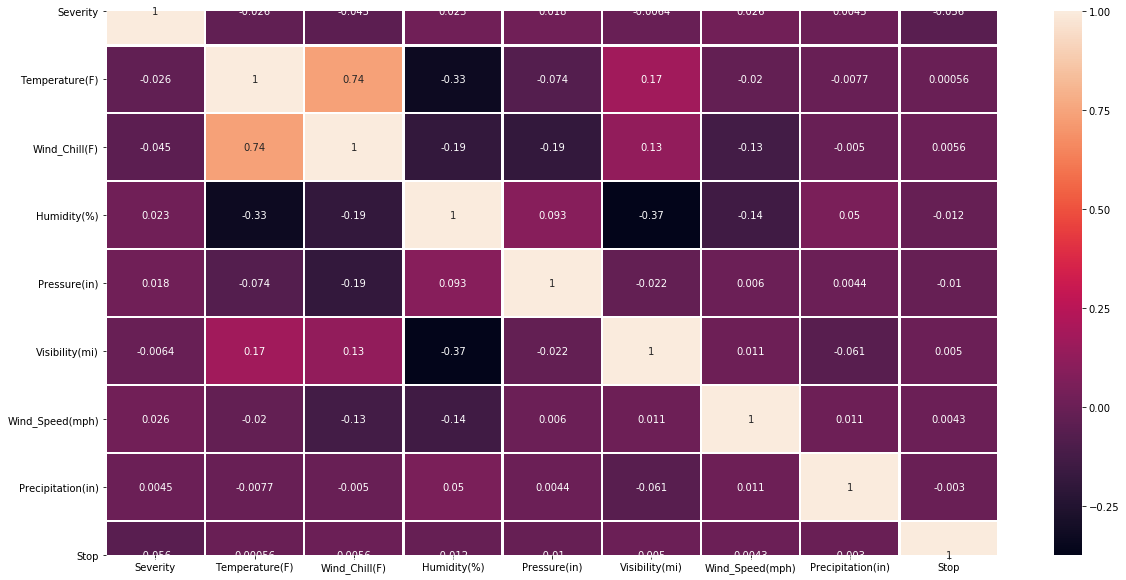

In [45]:
import seaborn as sea
import matplotlib.pyplot as plt
to_correlate = df.loc[:, ['Severity', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)','Start_Year','Stop']]
corrMatrix = to_correlate.corr()
fig, ax = plt.subplots(figsize=(20,10))
sea.heatmap(corrMatrix, annot=True, linewidths=1.5, ax=ax)

### Accidents and States

Text(0, 0.5, '')

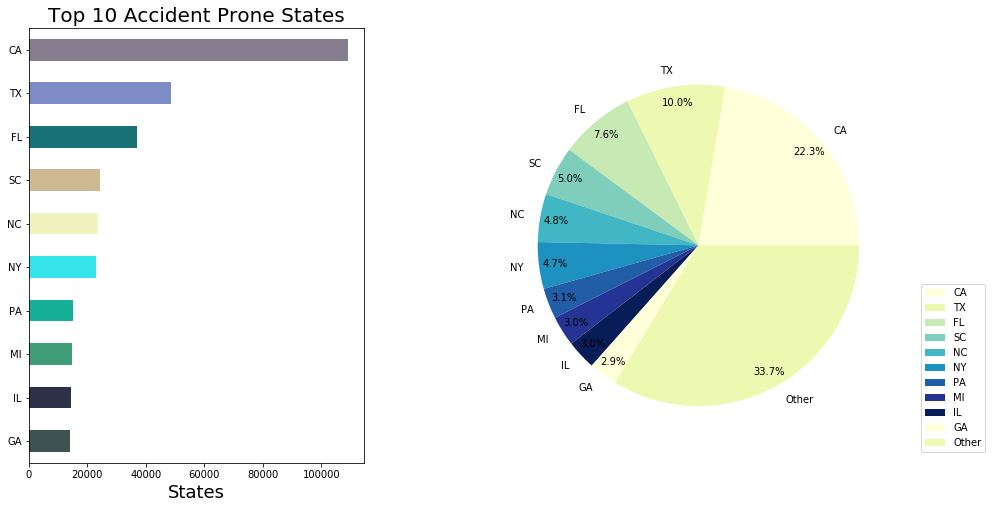

In [95]:
fig,ax=plt.subplots(1,2,figsize=(15,8))
clr = ("#3E5252", "#2D3047", "#419D78", "#15B097", "#34E4EA",'#F0F3BD','#CEB992','#197278','#7D8CC4','#857C8D')
df.State.value_counts().sort_values(ascending=False)[:10].sort_values().plot(kind='barh',color=clr,ax=ax[0])
ax[0].set_title("Top 10 Accident Prone States",size=20)
ax[0].set_xlabel('States',size=18)
count=df['State'].value_counts()
groups=list(df['State'].value_counts().index)[:10]
counts=list(count[:10])
counts.append(count.agg(sum)-count[:10].agg('sum'))
groups.append('Other')
type_dict=pd.DataFrame({"group":groups,"counts":counts})
clr1=("#ffffd9","#edf8b1","#c7e9b4","#7fcdbb","#41b6c4","#1d91c0","#225ea8","#253494","#081d58")
qx = type_dict.plot(kind='pie', y='counts', labels=groups,colors=clr1,autopct='%1.1f%%', pctdistance=0.9, radius=1.2,ax=ax[1])
plt.legend(loc=0, bbox_to_anchor=(1.15,0.4)) 
plt.subplots_adjust(wspace =0.5, hspace =0)
plt.ioff()
plt.ylabel('')


### Accidents and weather

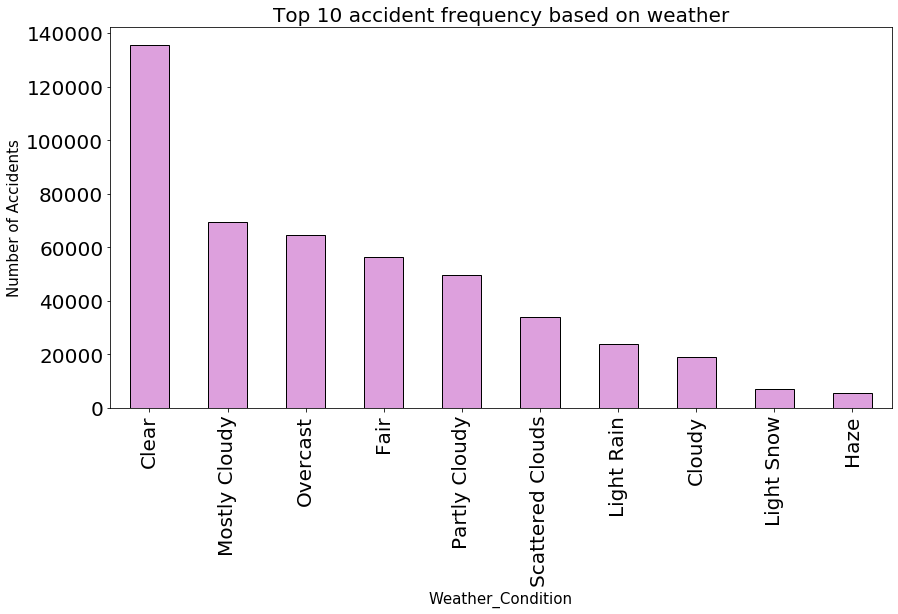

In [76]:
fig, ax=plt.subplots(figsize=(14,7))
df['Weather_Condition'].value_counts().sort_values(ascending=False).head(10).plot.bar(width=0.5,edgecolor='k',align='center',color ="plum")
plt.xlabel('Weather_Condition',fontsize=15)
plt.ylabel('Number of Accidents',fontsize=15)
ax.tick_params(labelsize=20)
plt.title('Top 10 accident frequency based on weather',fontsize=20)
plt.ioff()

### Accidents per Year

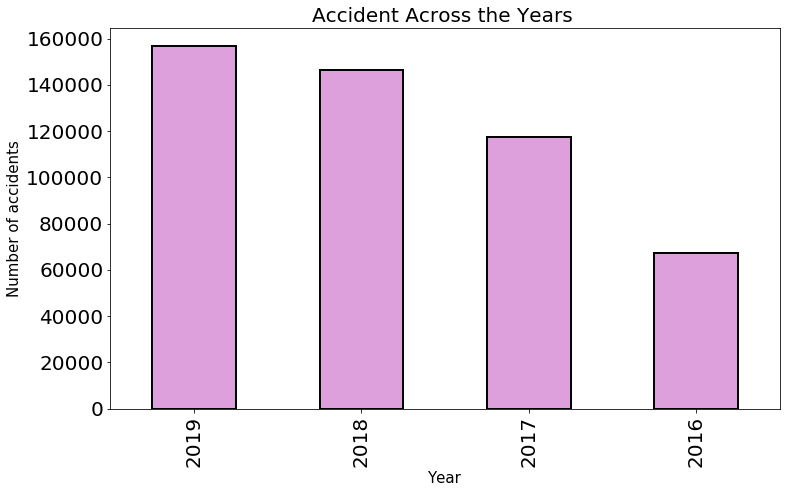

In [77]:
fig, ax=plt.subplots(figsize=(12,7))
df['Start_Year'].value_counts(ascending=False).plot.bar(width=0.5,edgecolor='k',align='center',linewidth=2,color ="plum")
plt.xlabel('Year',fontsize=15)
plt.ylabel('Number of accidents',fontsize=15)
ax.tick_params(labelsize=20)
plt.title('Accident Across the Years ',fontsize=20)
plt.ioff()

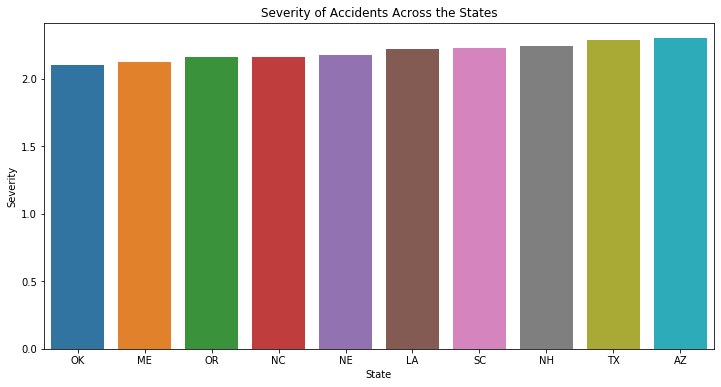

In [100]:
to_plot = df.groupby('State').agg({'Severity': 'mean'}).sort_values('Severity').reset_index().head(10)
plt.figure(figsize=(12,6))
sea.barplot(y="Severity", x="State", data=to_plot)
plt.title("Severity of Accidents Across the States")
plt.ioff()